# Notebook 3 of 4 - Feature Engineering and Modeling Part 1 (Unsupervised Learning)

**Code and Markdown Author:** _Muaaz Noor_

In this notebook, the wrangled and imputed data is taken and used to create additional features required for modeling. Additionally, some of the existent features are also tweaked according to the modeling needs.

In the second part of this notebook, unsupervised modeling approaches are tried on the data to see if any useful patterns/findings can be extracted to use as further features in supervised learning.

### Section 0: Setting up Libraries

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev
!pip install sparkmagic
!pip install s3fs
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import LeaveOneOutEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.spatial.distance import cdist

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning:

urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!



In [ ]:
%%capture
%load_ext sparkmagic.magics

In [ ]:
# Create Spark Sessions: Enter your Master Public DNS with the proper formatting and host, and update the password
%spark add -s spark_session -l python -u http://ec2-18-205-104-134.compute-1.amazonaws.com -a cis545-livy -p Peakcomedy69 -t Basic_Access

# If you ever need to restart, you may need to...
# %spark delete -s spark_session
#OR just factory reset runtime under the runtime tab

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1639508890632_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [ ]:
%%spark
from pyspark.sql.types import *

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Section 1: Loading and Further Wrangling Data

#### Load Data

In [ ]:
%%spark

raw_data_sdf = spark.read.options(header=True, inferSchema=True).csv('s3://cis545projectbmt/wrangle_data/part-00000-c84f734f-86af-42be-9edc-dc2e6ea5f2d7-c000.csv')
raw_data_sdf.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------+-----------------+---+---+-------------------+--------+----------------+-------+--------------------+---------+--------+----------------------+------------------+----------+---------------+--------+----+-----------+--------+------+------+----------+------------+----------+------------+-------------+------------+-----------+-------------------+---------------+--------------------+-------------------+--------------------+------------------+---------+-----+--------+--------+-----+-----+-----------+----------+------------+-------+----------+------------+-----+----------+---------------+------------------+---------------------+------------------------+
|year_month|cust_code|emp_status|residence_country|sex|age|first_contract_date|new_cust|months_as_senior|primary|last_date_as_primary|cust_type|rel_type|same_residence_country|diff_birth_country|emp_spouse|joining_channel|deceased|addr|province_cd|province|active|income|   segment|savings_acct|guarantees|curre

#### Income Imputation

Although we had initially planned to impute income using K-nearest neighbors imputation, that was computationally very expensive due to the large size of our dataset.<br>Therefore, we resorted to the next best option, imputing using the mean of income. This approach makes more sense than any other imputation method since income is a continuous variable, and imputing using mode would not have given the desired results.

In [ ]:
%%spark

raw_data_sdf.createOrReplaceTempView("raw_data")

mean_income = spark.sql('select mean(income) as mean_income from raw_data').collect()[0]['mean_income']
raw_data_sdf = raw_data_sdf.fillna(value=mean_income, subset=["income"])

raw_data_sdf.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------+-----------------+---+---+-------------------+--------+----------------+-------+--------------------+---------+--------+----------------------+------------------+----------+---------------+--------+----+-----------+--------+------+------+----------+------------+----------+------------+-------------+------------+-----------+-------------------+---------------+--------------------+-------------------+--------------------+------------------+---------+-----+--------+--------+-----+-----+-----------+----------+------------+-------+----------+------------+-----+----------+---------------+------------------+---------------------+------------------------+
|year_month|cust_code|emp_status|residence_country|sex|age|first_contract_date|new_cust|months_as_senior|primary|last_date_as_primary|cust_type|rel_type|same_residence_country|diff_birth_country|emp_spouse|joining_channel|deceased|addr|province_cd|province|active|income|   segment|savings_acct|guarantees|curre

#### Dropping Unnecessary Columns

In [ ]:
%%spark

raw_data_sdf = raw_data_sdf.drop('cc', 'ym', 'payroll', 'pensions_2', 'first_imputed_payroll', 'first_imputed_pensions_2')
raw_data_sdf.createOrReplaceTempView("raw_data")
raw_data_sdf.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------+-----------------+---+---+-------------------+--------+----------------+-------+--------------------+---------+--------+----------------------+------------------+----------+---------------+--------+----+-----------+--------+------+------+----------+------------+----------+------------+-------------+------------+-----------+-------------------+---------------+--------------------+-------------------+--------------------+------------------+---------+-----+--------+--------+-----+-----+-----------+----------+------------+------------+---------------+------------------+
|year_month|cust_code|emp_status|residence_country|sex|age|first_contract_date|new_cust|months_as_senior|primary|last_date_as_primary|cust_type|rel_type|same_residence_country|diff_birth_country|emp_spouse|joining_channel|deceased|addr|province_cd|province|active|income|   segment|savings_acct|guarantees|current_acct|derivada_acct|payroll_acct|junior_acct|max_particular_acct|particular_acct|

#### Scaling Down to One Month

Since our goal is to predict whether each customer will have a securities account in May 2016, we are only going to use data from April 2016 - while also incorporating additional features from the time series component of the data.<br>
Therefore, we will scale our data down to just the second last month (April 2016), and add the response variable *securities* from the last month (May 2016).

In [ ]:
%%spark

apr_sdf = spark.sql("select * from raw_data where year_month between '2016-04-01' and '2016-04-30'")
may_sdf = spark.sql("select * from raw_data where year_month between '2016-05-01' and '2016-05-31'")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

apr_sdf.createOrReplaceTempView('apr')
may_sdf.createOrReplaceTempView('may')

apr_sdf.show(10)
may_sdf.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------+-----------------+---+---+-------------------+--------+----------------+-------+--------------------+---------+--------+----------------------+------------------+----------+---------------+--------+----+-----------+--------+------+------+----------+------------+----------+------------+-------------+------------+-----------+-------------------+---------------+--------------------+-------------------+--------------------+------------------+---------+-----+--------+--------+-----+-----+-----------+----------+------------+------------+---------------+------------------+
|year_month|cust_code|emp_status|residence_country|sex|age|first_contract_date|new_cust|months_as_senior|primary|last_date_as_primary|cust_type|rel_type|same_residence_country|diff_birth_country|emp_spouse|joining_channel|deceased|addr|province_cd|province|active|income|   segment|savings_acct|guarantees|current_acct|derivada_acct|payroll_acct|junior_acct|max_particular_acct|particular_acct|

In [ ]:
%%spark

sdf_final = spark.sql('''select a.*, b.securities as securities_may from apr a
                      inner join may b
                      where a.cust_code==b.cust_code''')

sdf_final.createOrReplaceTempView('final')
sdf_final.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------+-----------------+---+---+-------------------+--------+----------------+-------+--------------------+---------+--------+----------------------+------------------+----------+---------------+--------+----+-----------+--------+------+------+----------+------------+----------+------------+-------------+------------+-----------+-------------------+---------------+--------------------+-------------------+--------------------+------------------+---------+-----+--------+--------+-----+-----+-----------+----------+------------+------------+---------------+------------------+--------------+
|year_month|cust_code|emp_status|residence_country|sex|age|first_contract_date|new_cust|months_as_senior|primary|last_date_as_primary|cust_type|rel_type|same_residence_country|diff_birth_country|emp_spouse|joining_channel|deceased|addr|province_cd|province|active|income|   segment|savings_acct|guarantees|current_acct|derivada_acct|payroll_acct|junior_acct|max_particular_acct|p

In [ ]:
%%spark

#Checking counts of customers that are present in both Apr and May
print(apr_sdf.count())
print(may_sdf.count())
print(sdf_final.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

926681
929578
925223

#### Response Variable

In [ ]:
%%spark

sdf = spark.sql('''select securities as sec_apr, securities_may as sec_may, count(*)
                from final
                group by sec_apr, sec_may''')

sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------+--------+
|sec_apr|sec_may|count(1)|
+-------+-------+--------+
|      1|      1|   21243|
|      0|      0|  903655|
|      0|      1|     183|
|      1|      0|     142|
+-------+-------+--------+

Our analysis shows that some of the customers close their securities account moving from April 2016 to May 2016. Thus, the scope of the response variable incorporates customers who would 'have' a securities account in May 2016 - whether these are customers who choose to keep their exisiting account, or are customers who open up a new securities account.

## Section 2: Feature Engineering

### Using Spark

This first subsection requires us to use Spark as the data in its current state is too large to handle in Pandas.

#### Number of Months per Account

For each type of account, we extract a feature from the time-series component that counts the number of months a customer has had that account.<br>
This process is repeated for each customer in our dataset.

In [ ]:
#Extract the number of months each account has been active for

%%spark

accounts = spark.sql('''select cust_code as cust_code_b, sum(case when savings_acct==1 then 1 else 0 end) as savings_acct_months,
                      sum(case when guarantees==1 then 1 else 0 end) as guarantees_months,
                      sum(case when current_acct==1 then 1 else 0 end) as cuurent_acct_months,
                      sum(case when derivada_acct==1 then 1 else 0 end) as derivada_acct_months,
                      sum(case when payroll_acct==1 then 1 else 0 end) as payroll_acct_months,
                      sum(case when junior_acct==1 then 1 else 0 end) as junior_acct_months,
                      sum(case when max_particular_acct==1 then 1 else 0 end) as max_particular_acct_months,
                      sum(case when particular_acct==1 then 1 else 0 end) as particular_acct_months,
                      sum(case when particular_plus_acct==1 then 1 else 0 end) as particular_plus_acct_months,
                      sum(case when short_term_deposits==1 then 1 else 0 end) as short_term_deposits_months,
                      sum(case when medium_term_deposits==1 then 1 else 0 end) as medium_term_deposits_months,
                      sum(case when long_term_deposits==1 then 1 else 0 end) as long_term_deposits_months,
                      sum(case when e_account==1 then 1 else 0 end) as e_account_months,
                      sum(case when funds==1 then 1 else 0 end) as funds_months,
                      sum(case when mortgage==1 then 1 else 0 end) as mortgage_months,
                      sum(case when pensions==1 then 1 else 0 end) as pensions_months,
                      sum(case when loans==1 then 1 else 0 end) as loans_months,
                      sum(case when taxes==1 then 1 else 0 end) as taxes_months,
                      sum(case when credit_card==1 then 1 else 0 end) as credit_card_months,
                      sum(case when home_account==1 then 1 else 0 end) as home_account_months,
                      sum(case when direct_debit==1 then 1 else 0 end) as direct_debit_months,
                      sum(case when imputed_payroll==1 then 1 else 0 end) as imputed_payroll_months,
                      sum(case when imputed_pensions_2==1 then 1 else 0 end) as imputed_pensions_2_months
                      from raw_data
                      where cust_code in (select cust_code from final)
                      group by cust_code''')

accounts.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------------------+-----------------+-------------------+--------------------+-------------------+------------------+--------------------------+----------------------+---------------------------+--------------------------+---------------------------+-------------------------+----------------+------------+---------------+---------------+------------+------------+------------------+-------------------+-------------------+----------------------+-------------------------+
|cust_code_b|savings_acct_months|guarantees_months|cuurent_acct_months|derivada_acct_months|payroll_acct_months|junior_acct_months|max_particular_acct_months|particular_acct_months|particular_plus_acct_months|short_term_deposits_months|medium_term_deposits_months|long_term_deposits_months|e_account_months|funds_months|mortgage_months|pensions_months|loans_months|taxes_months|credit_card_months|home_account_months|direct_debit_months|imputed_payroll_months|imputed_pensions_2_months|
+-----------+-------------

In [ ]:
#Joining the new account_months features with our original data

%%spark

accounts.createOrReplaceTempView('accounts')

sdf_final = spark.sql('''select a.*, b.* from final a
                      join accounts b on a.cust_code = b.cust_code_b''')
sdf_final = sdf_final.drop('cust_code_b')
sdf_final.createOrReplaceTempView('final')
sdf_final.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------+-----------------+---+---+-------------------+--------+----------------+-------+--------------------+---------+--------+----------------------+------------------+----------+---------------+--------+----+-----------+--------+------+------+----------+------------+----------+------------+-------------+------------+-----------+-------------------+---------------+--------------------+-------------------+--------------------+------------------+---------+-----+--------+--------+-----+-----+-----------+----------+------------+------------+---------------+------------------+--------------+-------------------+-----------------+-------------------+--------------------+-------------------+------------------+--------------------------+----------------------+---------------------------+--------------------------+---------------------------+-------------------------+----------------+------------+---------------+---------------+------------+------------+---------------

#### Changes in Customer Type

We count the number of times each customer has changed his/her customer type over the given time period, and save that as a numeric feature. We hope to use this feature as a measure of customer 'volatility' - we hypothesize that this may be linked to having a securities account as more volatile customers would have more risk appetite and would be wiling to invest in a securities account. We will explore this further in the modeling part of our project.

In [ ]:
#Extract the number of cust_type changes for each customer

%%spark

temp = spark.sql('''select a.cust_code as cust_code_b, count(*) as num_acc_changes
                            from raw_data a
                            join raw_data b
                            on b.year_month = add_months(a.year_month, 1)
                            and b.cust_code = a.cust_code
                            where a.cust_code in (select cust_code from final)
                            and a.cust_type <> b.cust_type
                            group by a.cust_code
                            order by num_acc_changes desc''')

temp.createOrReplaceTempView('temp')

temp = spark.sql('''select a.cust_code,
                  case when b.num_acc_changes <> 0 then b.num_acc_changes else 0 end as cust_type_changes
                  from final a
                  left join temp b
                  on a.cust_code = b.cust_code_b
                  order by cust_type_changes desc''')
temp.createOrReplaceTempView('temp')

temp.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------------+
|cust_code|cust_type_changes|
+---------+-----------------+
|   693087|                3|
|  1461305|                2|
|  1036738|                2|
|  1376219|                2|
|   779495|                2|
|  1510928|                2|
|  1477141|                2|
|  1429121|                2|
|  1534257|                2|
|  1464736|                2|
|  1428118|                2|
|  1415572|                2|
|  1402398|                2|
|  1110145|                2|
|  1369095|                2|
|  1404977|                2|
|  1438317|                2|
|   544091|                2|
|  1262656|                2|
|   624971|                2|
+---------+-----------------+
only showing top 20 rows

In [ ]:
#Check the count of customers for each number of cust_type changes

%%spark

sdf = spark.sql('select cust_type_changes, count(*) from temp group by cust_type_changes order by cust_type_changes')
sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+--------+
|cust_type_changes|count(1)|
+-----------------+--------+
|                0|  810040|
|                1|  115091|
|                2|      91|
|                3|       1|
+-----------------+--------+

In [ ]:
#Join the cust_type_changes feature with the original data

%%spark

sdf_final = spark.sql('''select a.*, b.cust_type_changes
                      from final a
                      join temp b
                      on a.cust_code = b.cust_code''')

sdf_final.createOrReplaceTempView('final')

sdf_final.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------+-----------------+---+---+-------------------+--------+----------------+-------+--------------------+---------+--------+----------------------+------------------+----------+---------------+--------+----+-----------+--------+------+------+----------+------------+----------+------------+-------------+------------+-----------+-------------------+---------------+--------------------+-------------------+--------------------+------------------+---------+-----+--------+--------+-----+-----+-----------+----------+------------+------------+---------------+------------------+--------------+-------------------+-----------------+-------------------+--------------------+-------------------+------------------+--------------------------+----------------------+---------------------------+--------------------------+---------------------------+-------------------------+----------------+------------+---------------+---------------+------------+------------+---------------

#### Changes in Relation Type

We count the number of times each customer has changed his/her relation type over the given time period, and save that as a numeric feature. This, too, is hypothesized to be a representation of customer volatility.

In [ ]:
#Extract the number of rel_type changes for each customer

%%spark

temp_2 = spark.sql('''select a.cust_code as cust_code_b, count(*) as num_acc_changes
                            from raw_data a
                            join raw_data b
                            on b.year_month = add_months(a.year_month, 1)
                            and b.cust_code = a.cust_code
                            where a.cust_code in (select cust_code from final)
                            and a.rel_type <> b.rel_type
                            group by a.cust_code
                            order by num_acc_changes desc''')

temp_2.createOrReplaceTempView('temp_2')

temp_2 = spark.sql('''select a.cust_code,
                  case when b.num_acc_changes <> 0 then b.num_acc_changes else 0 end as rel_type_changes
                  from final a
                  left join temp_2 b
                  on a.cust_code = b.cust_code_b''')
temp_2.createOrReplaceTempView('temp_2')

temp_2.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----------------+
|cust_code|rel_type_changes|
+---------+----------------+
|    15902|               0|
|    15974|               1|
|    15987|               0|
|    15991|               0|
|    15997|               0|
|    16024|               0|
|    16052|               0|
|    16114|               0|
|    16145|               0|
|    16155|               0|
|    16232|               0|
|    16240|               0|
|    16266|               0|
|    16274|               0|
|    16339|               0|
|    16510|               0|
|    16515|               0|
|    16533|               0|
|    16534|               0|
|    16543|               0|
+---------+----------------+
only showing top 20 rows

In [ ]:
#Check the count of customers for each number of rel_type changes

%%spark

sdf = spark.sql('select rel_type_changes, count(*) from temp_2 group by rel_type_changes order by rel_type_changes')
sdf.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+--------+
|rel_type_changes|count(1)|
+----------------+--------+
|               0|  752761|
|               1|   68985|
|               2|   75597|
|               3|   22029|
|               4|    4649|
|               5|     985|
|               6|     165|
|               7|      39|
|               8|       9|
|               9|       3|
|              10|       1|
+----------------+--------+

In [ ]:
#Join the cust_type_changes feature with the original data

%%spark

sdf_final = spark.sql('''select a.*, b.rel_type_changes
                      from final a
                      join temp_2 b
                      on a.cust_code = b.cust_code''')

sdf_final.createOrReplaceTempView('final')

sdf_final.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------+-----------------+---+---+-------------------+--------+----------------+-------+--------------------+---------+--------+----------------------+------------------+----------+---------------+--------+----+-----------+--------+------+------+----------+------------+----------+------------+-------------+------------+-----------+-------------------+---------------+--------------------+-------------------+--------------------+------------------+---------+-----+--------+--------+-----+-----+-----------+----------+------------+------------+---------------+------------------+--------------+-------------------+-----------------+-------------------+--------------------+-------------------+------------------+--------------------------+----------------------+---------------------------+--------------------------+---------------------------+-------------------------+----------------+------------+---------------+---------------+------------+------------+---------------

#### Exporting Data to S3

In [ ]:
%%spark

spark.sparkContext._jsc.hadoopConfiguration().set('fs.s3.canned.acl', 'BucketOwnerFullControl')
sc._jsc.hadoopConfiguration().set('fs.s3.canned.acl', 'BucketOwnerFullControl')

sdf_final.coalesce(1).write.format("csv").option("header","true").save('s3://cis545projectbmt/feature_engineering_2', mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Using Pandas

With a reduced dataset now with < 1 million rows as the time series has been collapsed into a stock-based metric for account tenure (number of months per account) rather than a stream of dummies, we can work on the rest of our analysis in Pandas.

#### Importing Data

In [ ]:
df = pd.read_csv('s3://cis545projectbmt/feature_engineering_2/part-00000-9d97d422-c5a4-4213-91e1-9288dfdda1fe-c000.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df.shape

(925223, 74)

In [ ]:
df.head()

,year_month,cust_code,emp_status,residence_country,sex,age,first_contract_date,new_cust,months_as_senior,primary,last_date_as_primary,cust_type,rel_type,same_residence_country,diff_birth_country,emp_spouse,joining_channel,deceased,addr,province_cd,province,active,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,loans,taxes,credit_card,securities,home_account,direct_debit,imputed_payroll,imputed_pensions_2,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes
0,2016-04-28,15902,B,ES,H,58,1995-01-16,0,255,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016-04-28,16232,N,ES,V,54,2001-02-20,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,149565,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2016-04-28,16274,N,ES,V,60,1995-03-17,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,96276,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016-04-28,16339,N,ES,V,55,1995-03-27,0,253,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,197736,top,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,1,1,0,0,0,17,0,17,0,0,0,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0
4,2016-04-28,16510,A,ES,H,47,1995-04-20,0,252,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,213265,top,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,1,0,1,1,1,1,0,0,16,0,17,0,0,17,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0


#### Months Since First Contract

We count the months since each customer had their first contract with the bank, and kept that as a numeric feature. This feature can be used an indicator of customer loyalty, since customers who are still with the bank after so many years since their first contract are more likely to be loyal to the bank, and keep using its services.

In [ ]:
#Change column to datetime

df['first_contract_date'] = pd.to_datetime(df['first_contract_date'])

In [ ]:
#Verify the data type

df['first_contract_date'].dtypes

dtype('<M8[ns]')

In [ ]:
#Create new feature months_since_first_contract

df['months_since_first_contract'] = (2016-df['first_contract_date'].dt.year)*12 + 4 - df['first_contract_date'].dt.month

df.head()

,year_month,cust_code,emp_status,residence_country,sex,age,first_contract_date,new_cust,months_as_senior,primary,last_date_as_primary,cust_type,rel_type,same_residence_country,diff_birth_country,emp_spouse,joining_channel,deceased,addr,province_cd,province,active,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,loans,taxes,credit_card,securities,home_account,direct_debit,imputed_payroll,imputed_pensions_2,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract
0,2016-04-28,15902,B,ES,H,58,1995-01-16,0,255,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255
1,2016-04-28,16232,N,ES,V,54,2001-02-20,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,149565,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182
2,2016-04-28,16274,N,ES,V,60,1995-03-17,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,96276,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253
3,2016-04-28,16339,N,ES,V,55,1995-03-27,0,253,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,197736,top,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,1,1,0,0,0,17,0,17,0,0,0,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253
4,2016-04-28,16510,A,ES,H,47,1995-04-20,0,252,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,213265,top,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,1,0,1,1,1,1,0,0,16,0,17,0,0,17,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252


#### Joining Channel

The variable *joining_channel* is categorical, and has a large number of categories. This is troublesome for our analysis since one hot encoding will substantially increase dimensionality.<br>
As a different approach, we decide to keep a subset of the most frequent joining channels as one hot encoded features. We conduct a further analysis on the data to choose a right number for the top most frequent joining channels.

In [ ]:
#Top 20 most frequent joining channels

df['joining_channel'].value_counts().head(20)

KHE      251667
KAT      205843
KFC      200576
KHQ       75001
KHM       28387
KFA       25644
KHK       16729
KHN       15706
KHD        7389
other      6150
RED        5883
KAS        5585
KAG        4660
KAY        4440
KAA        4299
KAB        4014
KAE        3293
KCC        3118
KBZ        3009
KFD        2951
Name: joining_channel, dtype: int64

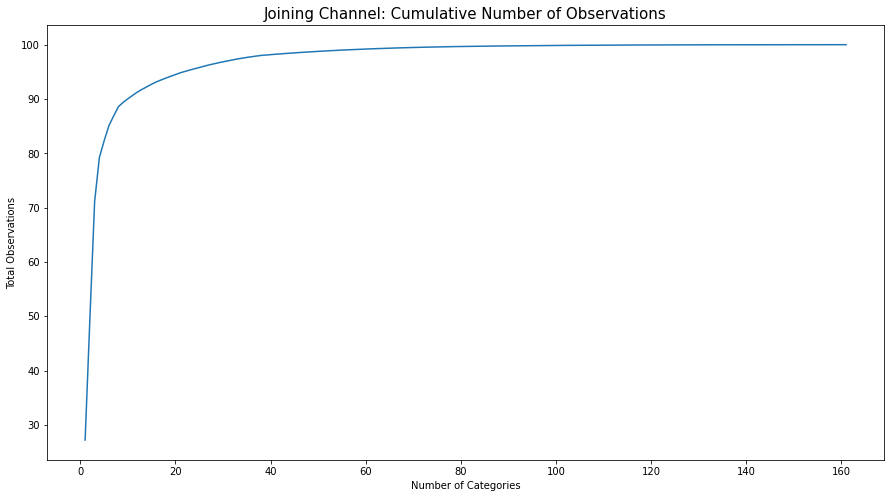

In [ ]:
#Plotting number of categories against cumulative sum of observations

cumsum = df['joining_channel'].value_counts().cumsum()*100/df.shape[0]
n_largest = [i for i in range(1,162)]

plt.figure(figsize=(15,8))
plt.xlabel('Number of Categories')
plt.ylabel('Total Observations')
plt.title('Joining Channel: Cumulative Number of Observations', fontdict={'fontsize': 15})
plt.plot(n_largest, cumsum)
plt.show()

The analysis shows that over 90% of the values are contained in the top 10 most frequent categories.<br> Instead of encoding all categories, we set a minimum count threshold of 5000 on each category to be represented as a one hot encoded variable.<br> The categories that do not specify the threshold were included in the 'others' categories.

In [ ]:
#Create dummy variables for top 11 joining channels (minimum count of 5000)

counts = pd.value_counts(df['joining_channel'])
mask = df['joining_channel'].isin(counts[counts > 5000].index)
df['joining_channel'][~mask] = "other"

#Add dummies as additional features in out original dataset, after removing the 'other' category
dummies = pd.get_dummies(df['joining_channel'], prefix = 'joining_channel').drop(columns='joining_channel_other')
dummies.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED
0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
#Join new features with original dataframe

df = pd.concat([df, dummies], axis=1)

df.head()

,year_month,cust_code,emp_status,residence_country,sex,age,first_contract_date,new_cust,months_as_senior,primary,last_date_as_primary,cust_type,rel_type,same_residence_country,diff_birth_country,emp_spouse,joining_channel,deceased,addr,province_cd,province,active,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,...,imputed_payroll,imputed_pensions_2,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED
0,2016-04-28,15902,B,ES,H,58,1995-01-16,0,255,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,17,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0
1,2016-04-28,16232,N,ES,V,54,2001-02-20,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,149565,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0
2,2016-04-28,16274,N,ES,V,60,1995-03-17,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,96276,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0
3,2016-04-28,16339,N,ES,V,55,1995-03-27,0,253,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,197736,top,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,...,1,1,0,0,0,17,0,17,0,0,0,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0
4,2016-04-28,16510,A,ES,H,47,1995-04-20,0,252,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,213265,top,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,...,1,1,1,0,0,16,0,17,0,0,17,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0


#### Is Residence Country Spain?

*residence_country* represents the country of resident for each customer. Since over 95% of the values had Spain as the resident country, we decided to store this information as a binary variable which represented whether the resident country is Spain or not.

In [ ]:
#Top 20 most common countries

df['residence_country'].value_counts().head(20)

ES    921235
FR       311
AR       288
GB       284
DE       280
US       229
CO       211
IT       180
RO       175
MX       156
BR       141
VE       139
EC       129
CH       122
BE        94
BO        92
PT        89
PY        86
CL        58
PE        54
Name: residence_country, dtype: int64

In [ ]:
#Create dummy variable for customers with resident country Spain

df['is_spain_residence_country'] = np.where(df['residence_country'] == 'ES', 1, 0)

df.is_spain_residence_country.value_counts()

1    921235
0      3988
Name: is_spain_residence_country, dtype: int64

#### Employee Status

*emp_status* represented whether a customer was also an employee of the bank. This variable had multiple categories for customers who were employees.<br>
Since the number of customers who were a sub-category of employee is very small, one hot encoding would have resulted in very sparse variables which would also increase the dimensionality of the data.<br>This information, therefore, is also stored as a binary variable indicating whether a customer is also an employee of the bank (In other words, merging all categories of being an employee into one).

In [ ]:
#Count for each catgeory of emp_status

df['emp_status'].value_counts()

N    924704
B       218
F       152
A       148
S         1
Name: emp_status, dtype: int64

In [ ]:
#Create new dummy is_employee

df['is_employee'] = np.where(df['emp_status'] == 'N', 0, 1)

df['is_employee'].value_counts()

0    924704
1       519
Name: is_employee, dtype: int64

####Customer Type

*cust_type* was a categorical column with 6 distinct categories.<br> After cleaning the variable, we created one-hot-encoded features and dropped the 'others' category.

In [ ]:
#Count of each category

df['cust_type'].value_counts()

1        741012
1        180158
other      3592
3           210
2            93
P            71
3            49
4            21
2            11
4             6
Name: cust_type, dtype: int64

In [ ]:
#Data Cleaning

df['cust_type'][df['cust_type'] == 1] = '1'
df['cust_type'][df['cust_type'] == 2] = '2'
df['cust_type'][df['cust_type'] == 3] = '3'
df['cust_type'][df['cust_type'] == 4] = '4'

df['cust_type'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying t

1        921170
other      3592
3           259
2           104
P            71
4            27
Name: cust_type, dtype: int64

In [ ]:
#Check mean of response variable for each category

grp = df.groupby(['cust_type']).mean()[['securities']]
grp.head()

,securities
cust_type,
1,0.023213
2,0.009615
3,0.000000
4,0.000000
P,0.000000


In [ ]:
#One hot Encoding

dummies = pd.get_dummies(df['cust_type'], prefix='cust_type')
dummies = dummies.drop(columns='cust_type_other')
dummies.head()

,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [ ]:
#Joining with original dataframe

df = pd.concat([df, dummies], axis=1)

df.head()

,year_month,cust_code,emp_status,residence_country,sex,age,first_contract_date,new_cust,months_as_senior,primary,last_date_as_primary,cust_type,rel_type,same_residence_country,diff_birth_country,emp_spouse,joining_channel,deceased,addr,province_cd,province,active,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,...,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P
0,2016-04-28,15902,B,ES,H,58,1995-01-16,0,255,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0
1,2016-04-28,16232,N,ES,V,54,2001-02-20,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,149565,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,2016-04-28,16274,N,ES,V,60,1995-03-17,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,96276,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,2016-04-28,16339,N,ES,V,55,1995-03-27,0,253,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,197736,top,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,...,17,0,0,0,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,2016-04-28,16510,A,ES,H,47,1995-04-20,0,252,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,213265,top,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,...,17,0,0,17,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0


#### Relation Type

*rel_type* has 5 categories. We decided to one-hot-encode this variable into 4 new features, after dropping the 'other' category.

In [ ]:
#Check count of each category

df['rel_type'].value_counts()

I        531150
A        390124
other      3592
P           286
R            71
Name: rel_type, dtype: int64

In [ ]:
#One Hot Encoding

dummies = pd.get_dummies(df['rel_type'], prefix='rel_type').drop(columns='rel_type_other')

dummies.head()

,rel_type_A,rel_type_I,rel_type_P,rel_type_R
0,1,0,0,0
1,0,1,0,0
2,0,1,0,0
3,1,0,0,0
4,1,0,0,0


In [ ]:
#Joining with Original Dataframe

df = pd.concat([df, dummies], axis=1)

df.head()

,year_month,cust_code,emp_status,residence_country,sex,age,first_contract_date,new_cust,months_as_senior,primary,last_date_as_primary,cust_type,rel_type,same_residence_country,diff_birth_country,emp_spouse,joining_channel,deceased,addr,province_cd,province,active,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,...,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,rel_type_I,rel_type_P,rel_type_R
0,2016-04-28,15902,B,ES,H,58,1995-01-16,0,255,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0
1,2016-04-28,16232,N,ES,V,54,2001-02-20,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,149565,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
2,2016-04-28,16274,N,ES,V,60,1995-03-17,0,253,1,NaN,1,I,S,N,N,KAT,N,1,28,MADRID,0,96276,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
3,2016-04-28,16339,N,ES,V,55,1995-03-27,0,253,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,197736,top,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,...,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4,2016-04-28,16510,A,ES,H,47,1995-04-20,0,252,1,NaN,1,A,S,N,N,KAT,N,1,28,MADRID,1,213265,top,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,...,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0


#### Binary Encoding Relevant Variables

Some of the variables in our data had only two categories. We binary encoded them representing '1' when the condition of the variable is true, and '0' otherwise.

In [ ]:
#Check counts of each category

df['deceased'].value_counts()

N    922939
S      2284
Name: deceased, dtype: int64

In [ ]:
#Check counts of each category

df['diff_birth_country'].value_counts()

N    879598
S     45625
Name: diff_birth_country, dtype: int64

In [ ]:
#Check counts of each category

df['sex'].value_counts()

V    502039
H    423184
Name: sex, dtype: int64

In [ ]:
#Check counts for each category

df['active'].value_counts()

0    531274
1    393949
Name: active, dtype: int64

In [ ]:
#Binary Encoding

df['deceased'] = np.where(df['deceased'] == 'S', 1, 0)
df['diff_birth_country'] = np.where(df['diff_birth_country'] == 'S', 1, 0)
df['is_male'] = np.where(df['sex'] == 'V', 1, 0)


df.head()

,year_month,cust_code,emp_status,residence_country,sex,age,first_contract_date,new_cust,months_as_senior,primary,last_date_as_primary,cust_type,rel_type,same_residence_country,diff_birth_country,emp_spouse,joining_channel,deceased,addr,province_cd,province,active,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,...,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,rel_type_I,rel_type_P,rel_type_R,is_male
0,2016-04-28,15902,B,ES,H,58,1995-01-16,0,255,1,NaN,1,A,S,0,N,KAT,0,1,28,MADRID,1,230408,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0
1,2016-04-28,16232,N,ES,V,54,2001-02-20,0,253,1,NaN,1,I,S,0,N,KAT,0,1,28,MADRID,0,149565,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1
2,2016-04-28,16274,N,ES,V,60,1995-03-17,0,253,1,NaN,1,I,S,0,N,KAT,0,1,28,MADRID,0,96276,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1
3,2016-04-28,16339,N,ES,V,55,1995-03-27,0,253,1,NaN,1,A,S,0,N,KAT,0,1,28,MADRID,1,197736,top,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
4,2016-04-28,16510,A,ES,H,47,1995-04-20,0,252,1,NaN,1,A,S,0,N,KAT,0,1,28,MADRID,1,213265,top,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,...,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0


#### Province

The *province* column had 53 categories. Since the distribution of customers is not too skewed towards a few of the provinces (shown below), we couldn't encode a subset of the categories. On the other hand, encoding all of the categories would have significantly increased the dimensionality for our data.<br>To overcome this problem, we encoded the variable using Leave One Out Encoding. However, we keep the original province labels as a new column, *province_actual_labels*, in our dataset so we can use it for interpretation in our tree based models further.

In [ ]:
#Check counts for each province

df['province'].value_counts()

MADRID                    296930
BARCELONA                  88146
VALENCIA                   47758
SEVILLA                    40297
CORUÑA, A                  28617
MURCIA                     27604
MALAGA                     24374
ZARAGOZA                   23090
ALICANTE                   21977
CADIZ                      19684
PONTEVEDRA                 18891
ASTURIAS                   18219
PALMAS, LAS                16235
VALLADOLID                 15975
BADAJOZ                    12891
TOLEDO                     12608
BIZKAIA                    12422
GRANADA                    12316
SALAMANCA                  11041
CANTABRIA                  10739
CORDOBA                     9775
BALEARS, ILLES              9064
CACERES                     8570
CIUDAD REAL                 8044
HUELVA                      7987
ALBACETE                    7749
TARRAGONA                   7587
CASTELLON                   7107
BURGOS                      6621
GIRONA                      6266
NAVARRA   

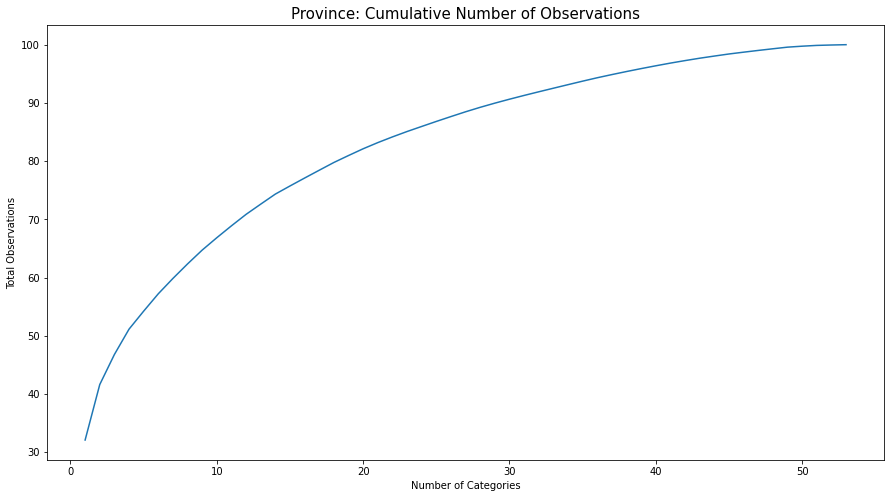

In [ ]:
#Plotting number of categories against cummulative sum of observations

cumsum = df['province'].value_counts().cumsum()*100/df.shape[0]
n_largest = [i for i in range(1,54)]

plt.figure(figsize=(15,8))
plt.xlabel('Number of Categories')
plt.ylabel('Total Observations')
plt.title('Province: Cumulative Number of Observations', fontdict={'fontsize': 15})
plt.plot(n_largest, cumsum)
plt.show()

The analysis shows that around 40 of the top most frequent provinces cover 95% of the observations. Encoding 40 categories would still significantly increase the dimensionality, so subsetting the categories is not a solution in this case.


In [ ]:
#Check mean of response variable for each province

df.groupby(['province']).mean()['securities']

province
ALAVA                     0.038029
ALBACETE                  0.008001
ALICANTE                  0.014652
ALMERIA                   0.015673
ASTURIAS                  0.019979
AVILA                     0.014095
BADAJOZ                   0.007369
BALEARS, ILLES            0.018976
BARCELONA                 0.018413
BIZKAIA                   0.035099
BURGOS                    0.018275
CACERES                   0.007935
CADIZ                     0.013412
CANTABRIA                 0.034268
CASTELLON                 0.014211
CEUTA                     0.023715
CIUDAD REAL               0.013178
CORDOBA                   0.013913
CORUÑA, A                 0.011497
CUENCA                    0.010048
GIPUZKOA                  0.032763
GIRONA                    0.013246
GRANADA                   0.012585
GUADALAJARA               0.020636
HUELVA                    0.007637
HUESCA                    0.020151
JAEN                      0.018377
LEON                      0.024639
LERIDA     

In [ ]:
#Leave One Out Encoding

#Splitting data into features (X) and Target (y)
X = df.drop(columns=['securities', 'securities_may'])
y = df['securities_may']

#Encoding the province column
enc = LeaveOneOutEncoder(cols=['province'])
X = enc.fit_transform(X, y)

df['province_actual_labels'] = df['province'] #Save original province labels as an additional column in dataset
df['province'] = X['province']

df.head()

,year_month,cust_code,emp_status,residence_country,sex,age,first_contract_date,new_cust,months_as_senior,primary,last_date_as_primary,cust_type,rel_type,same_residence_country,diff_birth_country,emp_spouse,joining_channel,deceased,addr,province_cd,province,active,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,...,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,rel_type_I,rel_type_P,rel_type_R,is_male,province_actual_labels
0,2016-04-28,15902,B,ES,H,58,1995-01-16,0,255,1,NaN,1,A,S,0,N,KAT,0,1,28,0.037073,1,230408,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,MADRID
1,2016-04-28,16232,N,ES,V,54,2001-02-20,0,253,1,NaN,1,I,S,0,N,KAT,0,1,28,0.037073,0,149565,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,MADRID
2,2016-04-28,16274,N,ES,V,60,1995-03-17,0,253,1,NaN,1,I,S,0,N,KAT,0,1,28,0.037073,0,96276,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,MADRID
3,2016-04-28,16339,N,ES,V,55,1995-03-27,0,253,1,NaN,1,A,S,0,N,KAT,0,1,28,0.037073,1,197736,top,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,MADRID
4,2016-04-28,16510,A,ES,H,47,1995-04-20,0,252,1,NaN,1,A,S,0,N,KAT,0,1,28,0.037069,1,213265,top,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,...,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,MADRID


####Segment

*segment* had 4 categories, which were encoded into 3 seperate variables, after dropping the 'other' category.

In [ ]:
#Check counts of each category

df['segment'].value_counts()

individual           537736
graduate_academic    346235
top                   34814
other                  6438
Name: segment, dtype: int64

In [ ]:
#One Hot Encoding

dummies = pd.get_dummies(df['segment'], prefix='segment').drop(columns='segment_other')
dummies.head()

,segment_graduate_academic,segment_individual,segment_top
0,0,0,1
1,0,1,0
2,0,1,0
3,0,0,1
4,0,0,1


In [ ]:
#Join with original dataframe

df = pd.concat([df, dummies], axis=1)

df.head()

,year_month,cust_code,emp_status,residence_country,sex,age,first_contract_date,new_cust,months_as_senior,primary,last_date_as_primary,cust_type,rel_type,same_residence_country,diff_birth_country,emp_spouse,joining_channel,deceased,addr,province_cd,province,active,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,...,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,rel_type_I,rel_type_P,rel_type_R,is_male,province_actual_labels,segment_graduate_academic,segment_individual,segment_top
0,2016-04-28,15902,B,ES,H,58,1995-01-16,0,255,1,NaN,1,A,S,0,N,KAT,0,1,28,0.037073,1,230408,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,MADRID,0,0,1
1,2016-04-28,16232,N,ES,V,54,2001-02-20,0,253,1,NaN,1,I,S,0,N,KAT,0,1,28,0.037073,0,149565,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,MADRID,0,1,0
2,2016-04-28,16274,N,ES,V,60,1995-03-17,0,253,1,NaN,1,I,S,0,N,KAT,0,1,28,0.037073,0,96276,individual,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,MADRID,0,1,0
3,2016-04-28,16339,N,ES,V,55,1995-03-27,0,253,1,NaN,1,A,S,0,N,KAT,0,1,28,0.037073,1,197736,top,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,...,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,MADRID,0,0,1
4,2016-04-28,16510,A,ES,H,47,1995-04-20,0,252,1,NaN,1,A,S,0,N,KAT,0,1,28,0.037069,1,213265,top,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,...,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,MADRID,0,0,1


#### Dropping Irrelevant Columns

We decide to drop some of the features from our data, since they either represented redundant information, or were not important for our analysis. The reasons for removing some of these variables are given below:<br><br>

*primary*: Drop because all values are 1s<br>
*emp_spouse*: Drop because only 1 customer had employee spouse<br>
*addr*: Drop because all values are 1s<br>
*same_residence_country*: Drop because another feature represents the same information<br><br>
All other columns are dropped because the relevant information from them was extracted in the form of other variables (in the feature engineering portion above).

In [ ]:
#drop columns

df = df.drop(columns=['year_month', 'first_contract_date', 'primary', 'last_date_as_primary', 'emp_spouse',
                    'emp_status', 'residence_country', 'sex', 'first_contract_date', 'primary',
                    'last_date_as_primary', 'cust_type', 'rel_type', 'same_residence_country',
                    'emp_spouse', 'joining_channel','addr', 'province_cd', 'segment', 'securities'])

df.head()

,cust_code,age,new_cust,months_as_senior,diff_birth_country,deceased,province,active,income,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,loans,taxes,credit_card,home_account,direct_debit,imputed_payroll,imputed_pensions_2,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,...,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,rel_type_I,rel_type_P,rel_type_R,is_male,province_actual_labels,segment_graduate_academic,segment_individual,segment_top
0,15902,58,0,255,0,0,0.037073,1,230408,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,MADRID,0,0,1
1,16232,54,0,253,0,0,0.037073,0,149565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,MADRID,0,1,0
2,16274,60,0,253,0,0,0.037073,0,96276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,MADRID,0,1,0
3,16339,55,0,253,0,0,0.037073,1,197736,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,17,0,17,0,0,...,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,MADRID,0,0,1
4,16510,47,0,252,0,0,0.037069,1,213265,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,0,1,1,1,1,0,0,16,0,17,0,0,...,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,MADRID,0,0,1


In [ ]:
#Set cust_code as index

df = df.set_index('cust_code')

df.head()

,age,new_cust,months_as_senior,diff_birth_country,deceased,province,active,income,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,loans,taxes,credit_card,home_account,direct_debit,imputed_payroll,imputed_pensions_2,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,...,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,rel_type_I,rel_type_P,rel_type_R,is_male,province_actual_labels,segment_graduate_academic,segment_individual,segment_top
cust_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15902,58,0,255,0,0,0.037073,1,230408,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,MADRID,0,0,1
16232,54,0,253,0,0,0.037073,0,149565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,MADRID,0,1,0
16274,60,0,253,0,0,0.037073,0,96276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,MADRID,0,1,0
16339,55,0,253,0,0,0.037073,1,197736,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,17,0,17,0,0,0,...,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,MADRID,0,0,1
16510,47,0,252,0,0,0.037069,1,213265,0,0,1,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,0,1,1,1,1,0,0,16,0,17,0,0,17,...,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,MADRID,0,0,1


### Correlation Heatmap

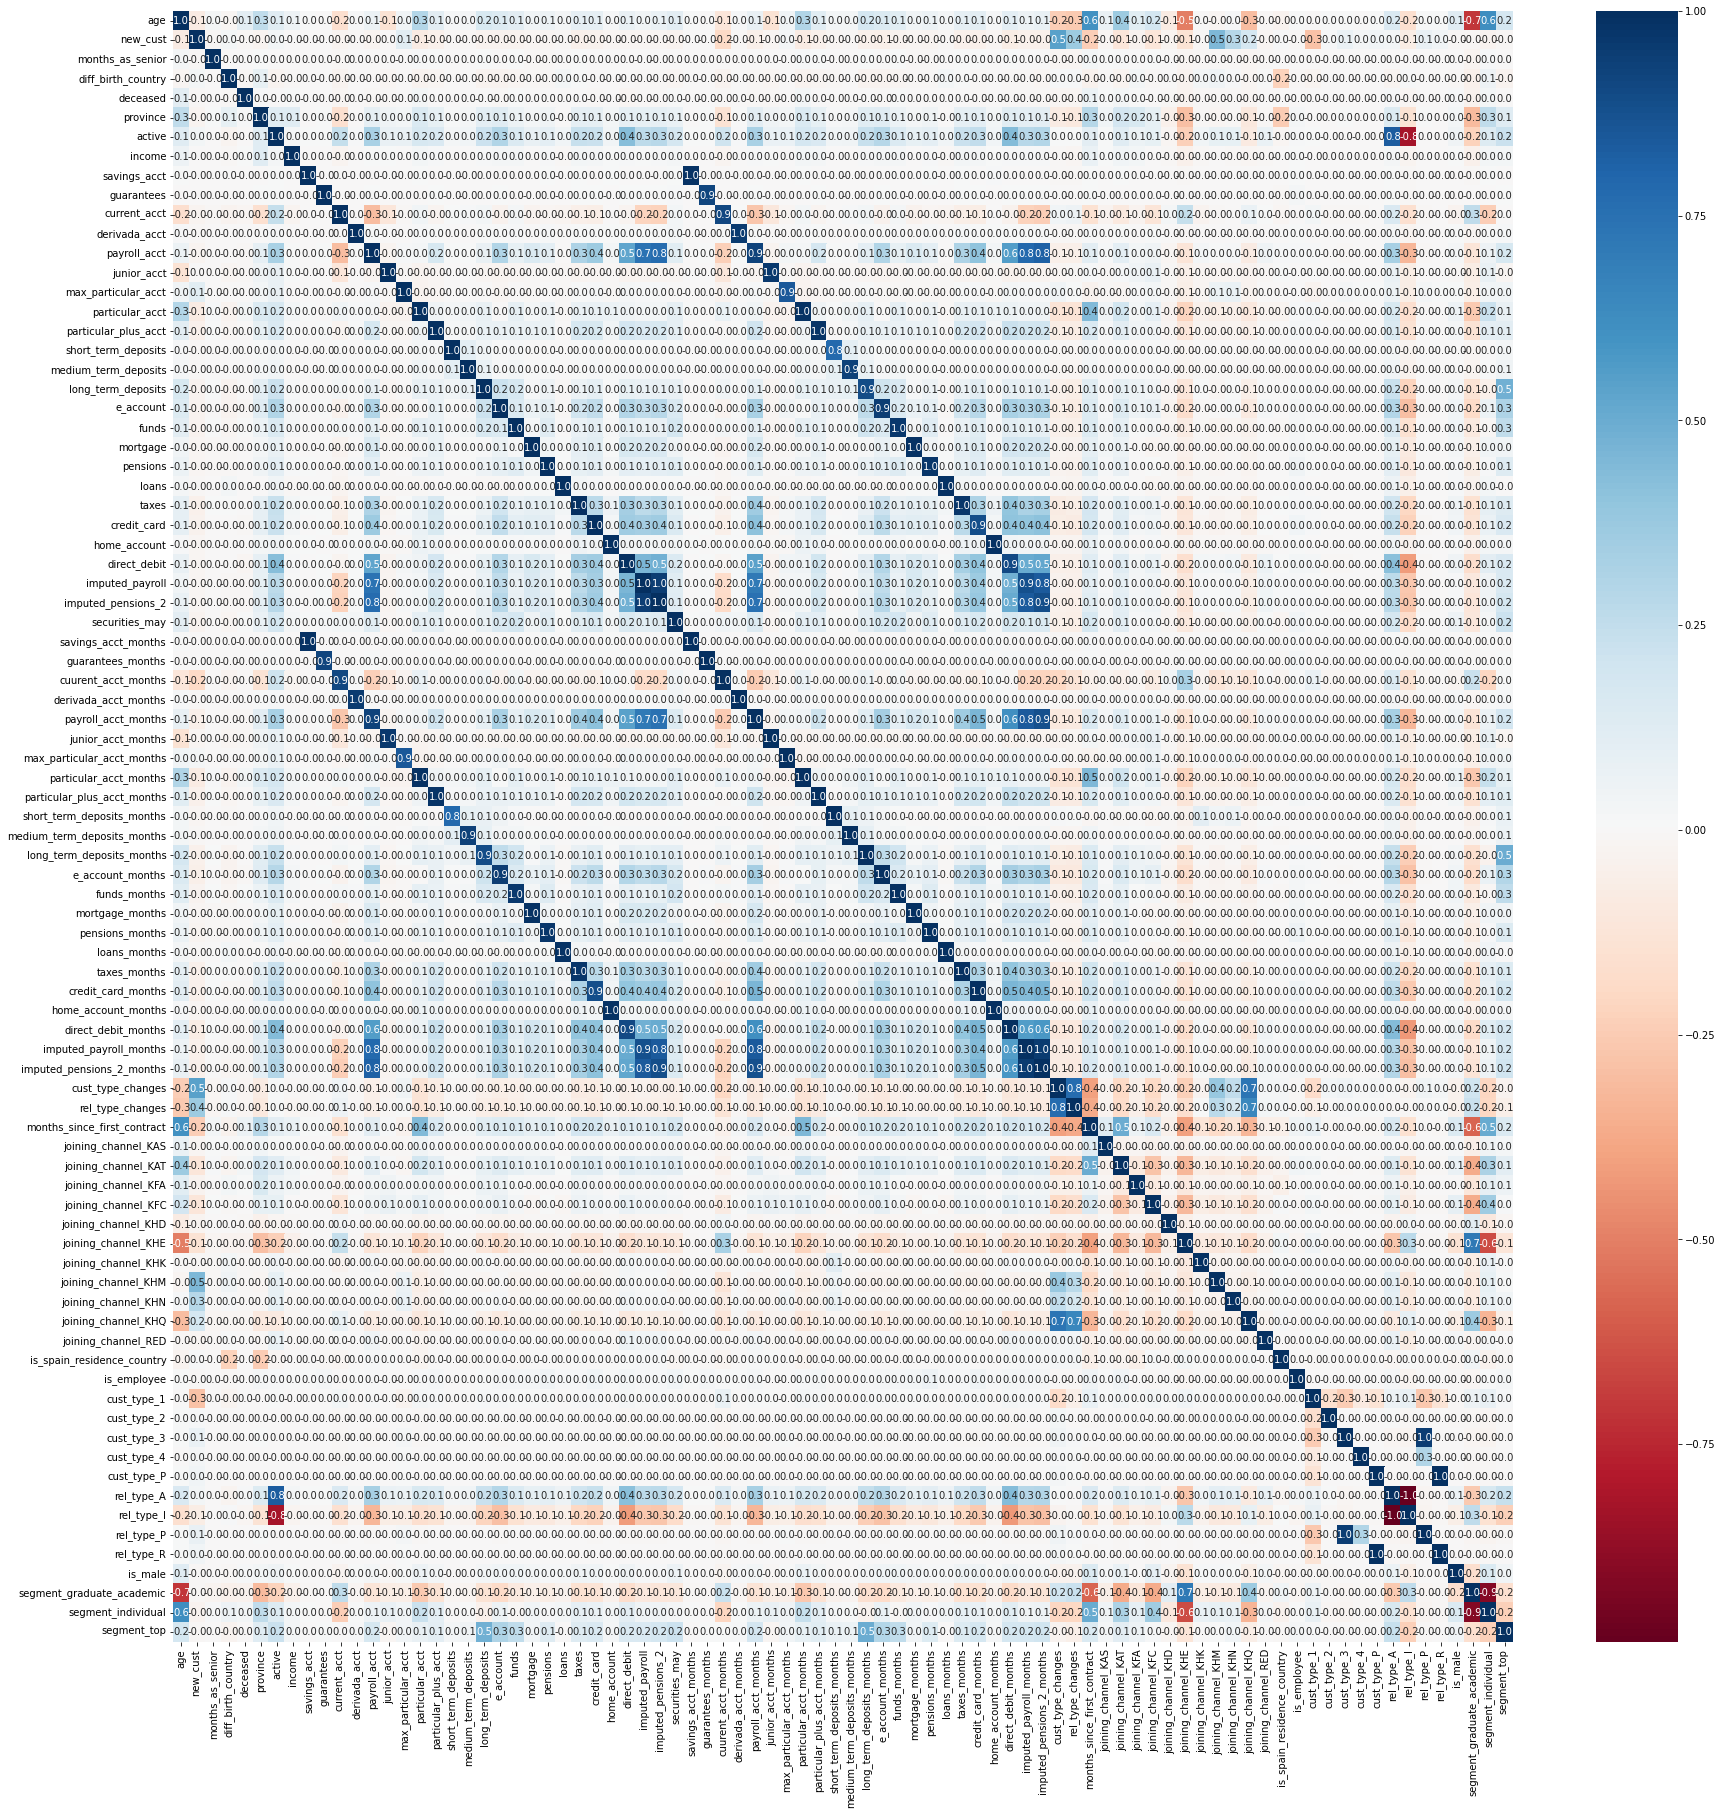

In [ ]:
cor = df.corr()

plt.figure(figsize=(30,30))
sns.heatmap(cor, annot=True, fmt='.1f', cmap='RdBu')
plt.show()

#### Addressing Multicolinearity

<br>The analysis shows that there is perfect, or almost perfect, correlation between our newly created *_months* features and the original features for each account. Since they store the same, or highly similar, information, we dropped the original account features and kept only the *_months* features.<br><br>
Similarly, *rel_type_P* and *rel_type_R* are perfectly correlated with *cust_type_former primary* and *cust_type_potential*, so we drop the two relation type features and only keep the customer type features in our final dataset.<br><br>
*rel_type_I* can be dropped because it has a perfect inverse relationship with *rel_type_A* so it does not make sense to keep both.

In [ ]:
#Dropping correlated features

df = df.drop(columns = ['savings_acct', 'guarantees', 'current_acct', 'derivada_acct', 'payroll_acct', 'junior_acct',
                      'max_particular_acct', 'particular_acct', 'particular_plus_acct', 'short_term_deposits',
                      'long_term_deposits', 'e_account', 'funds', 'mortgage', 'pensions', 'loans', 'taxes',
                      'credit_card', 'home_account', 'direct_debit', 'imputed_payroll', 'imputed_pensions_2',
                      'medium_term_deposits'])
df = df.drop(columns = ['rel_type_P', 'rel_type_R', 'rel_type_I'])

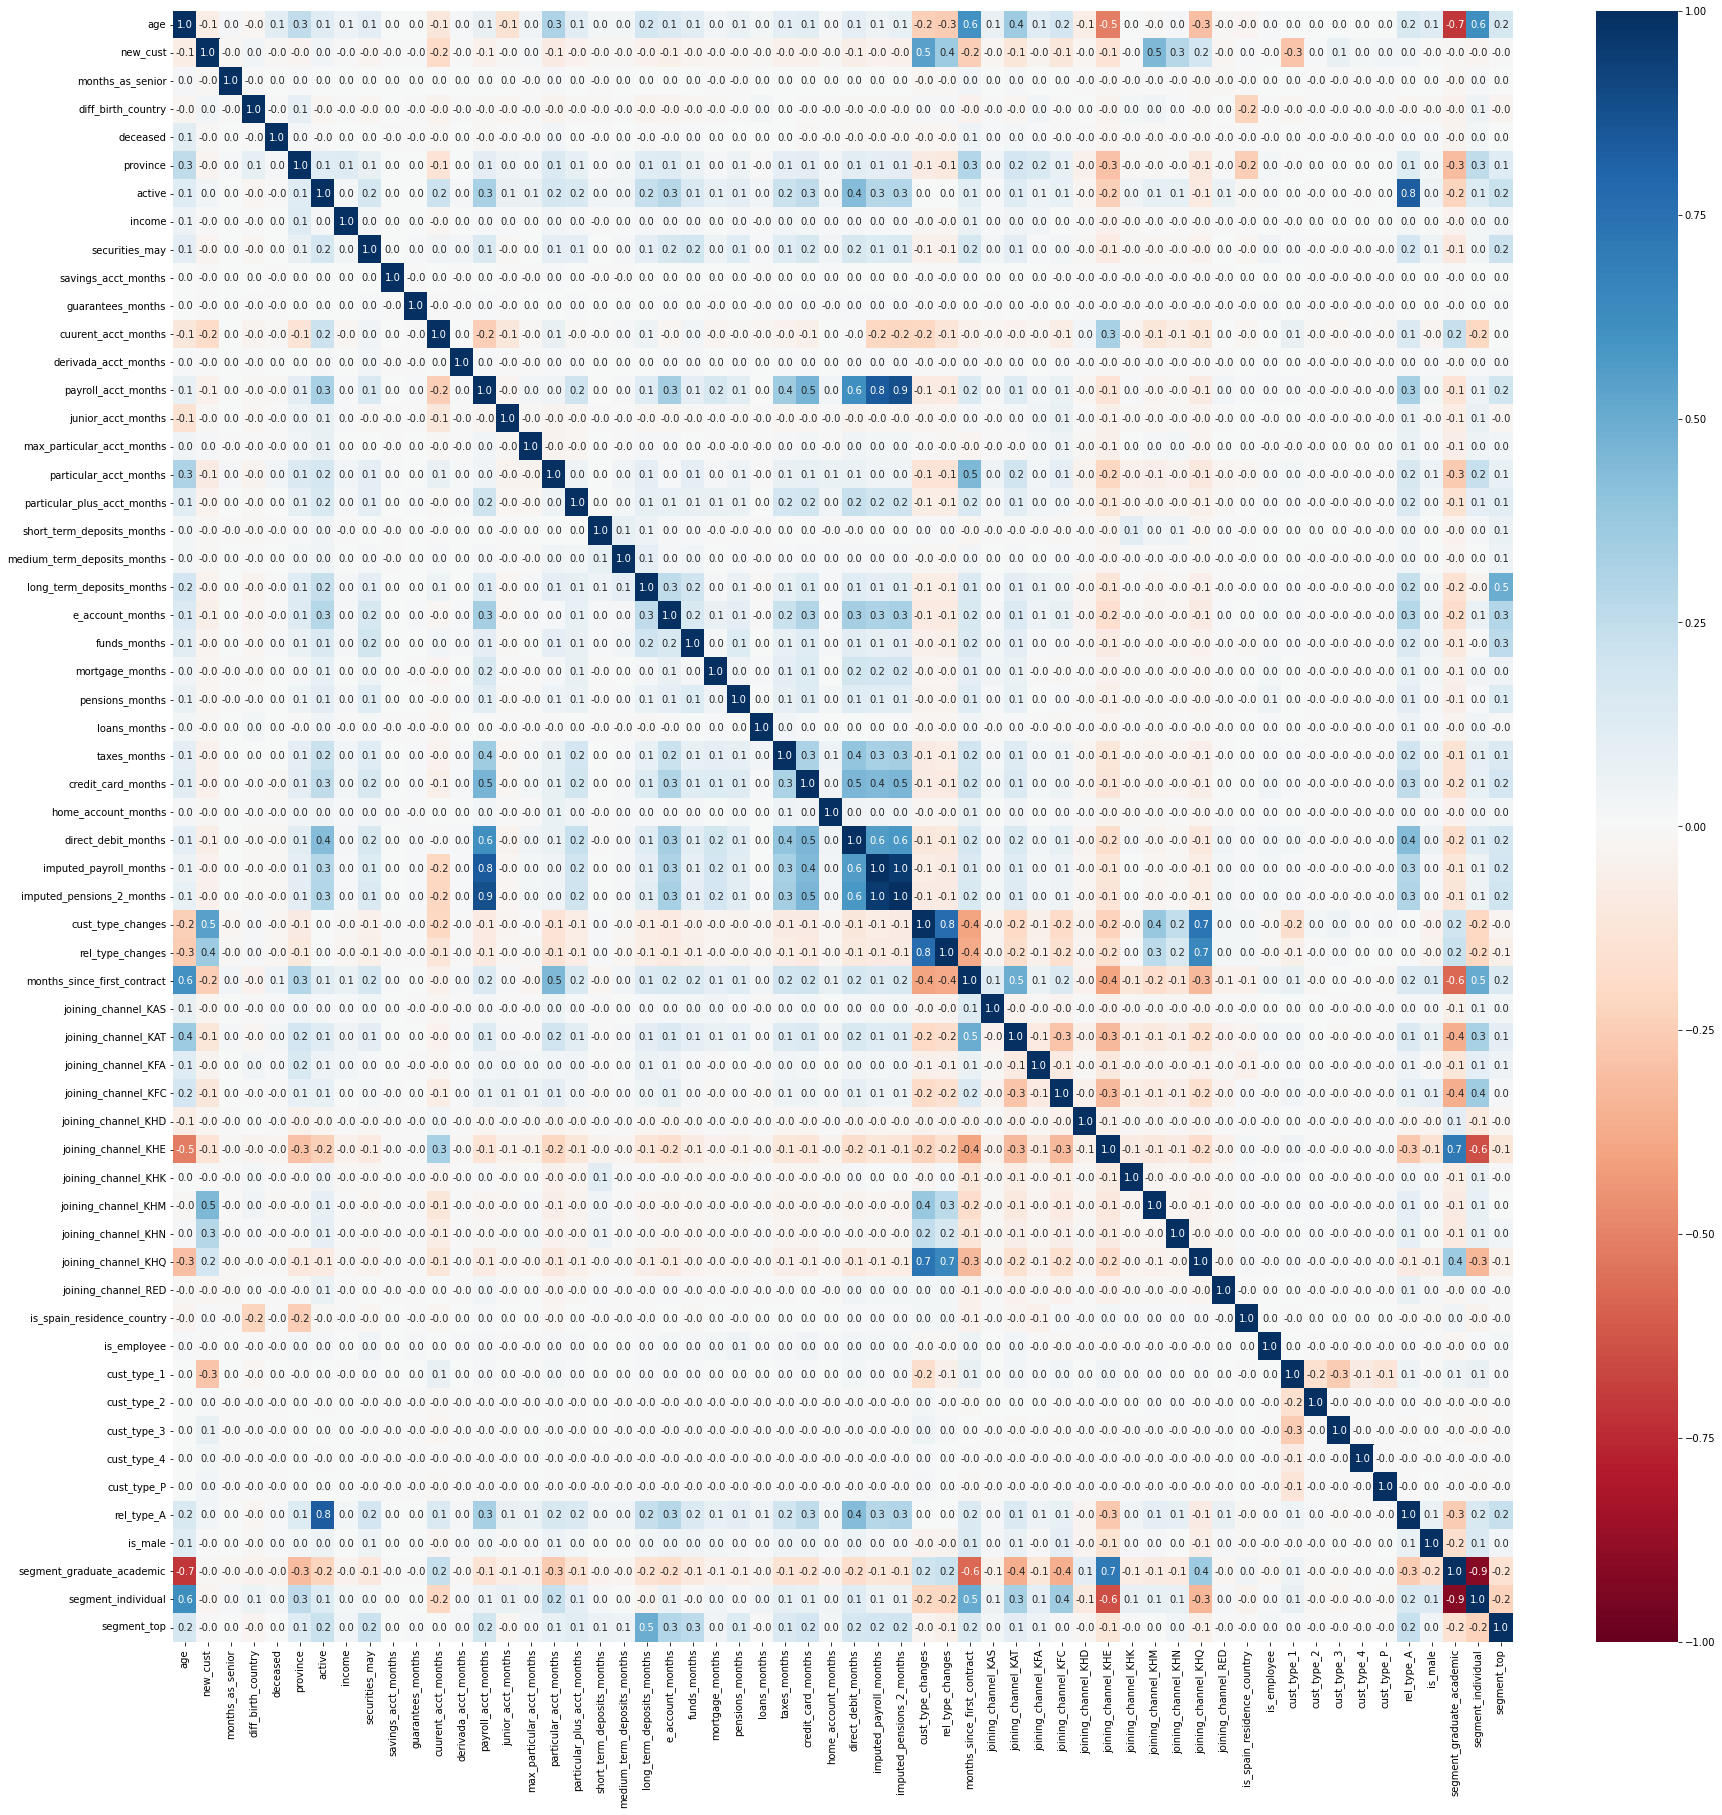

In [ ]:
cor = df.corr()

plt.figure(figsize=(30,30))
sns.heatmap(cor, annot=True, fmt='.1f', cmap='RdBu', vmin=-1, vmax=1)
plt.show()

In [ ]:
df.head()

,age,new_cust,months_as_senior,diff_birth_country,deceased,province,active,income,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,is_male,province_actual_labels,segment_graduate_academic,segment_individual,segment_top
cust_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15902,58,0,255,0,0,0.037073,1,230408,0,0,0,17,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1
16232,54,0,253,0,0,0.037073,0,149565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0
16274,60,0,253,0,0,0.037073,0,96276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0
16339,55,0,253,0,0,0.037073,1,197736,0,0,0,17,0,17,0,0,0,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,MADRID,0,0,1
16510,47,0,252,0,0,0.037069,1,213265,1,0,0,16,0,17,0,0,17,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1


In [ ]:
print('Number of Columns: ' + str(len(df.columns)))

Number of Columns: 59


#### Saving CSV to Google Drive (Checkpoint)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_csv('/content/drive/MyDrive/CIS 545 Project/feat_eng_2.csv')

# Section 3: Modeling (Part I) - Unsupervised Learning

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CIS 545 Project/feat_eng_2.csv').set_index('cust_code')

df.head()

,age,new_cust,months_as_senior,diff_birth_country,deceased,province,active,income,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,is_male,province_actual_labels,segment_graduate_academic,segment_individual,segment_top
cust_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15902,58,0,255,0,0,0.037073,1,230408,0,0,0,17,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1
16232,54,0,253,0,0,0.037073,0,149565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0
16274,60,0,253,0,0,0.037073,0,96276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0
16339,55,0,253,0,0,0.037073,1,197736,0,0,0,17,0,17,0,0,0,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,MADRID,0,0,1
16510,47,0,252,0,0,0.037069,1,213265,1,0,0,16,0,17,0,0,17,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1


## Principal Component Analysis

Since we have a very high number of features, we perform PCA on our data to see if the number of dimensions can be reduuced while still being able to capture important information from our data.

#### Scaling Numerical Features

To perform PCA, we first need to standardize our data so that all of our features are on roighly the same scale. To achieve this, we only standardize the numeric features, and leave all the binary features as they are.

In [ ]:
num_X = df[['age', 'months_as_senior', 'province', 'income',
                 'savings_acct_months', 'guarantees_months', 'cuurent_acct_months', 'derivada_acct_months',
                 'payroll_acct_months', 'junior_acct_months', 'max_particular_acct_months', 
                 'particular_acct_months', 'particular_plus_acct_months', 'short_term_deposits_months',
                  'long_term_deposits_months', 'e_account_months', 'funds_months', 'mortgage_months',
                  'pensions_months', 'loans_months', 'taxes_months', 'credit_card_months', 'home_account_months',
                  'direct_debit_months', 'imputed_payroll_months', 'imputed_pensions_2_months',
                  'medium_term_deposits_months', 'cust_type_changes', 'rel_type_changes',
                 'months_since_first_contract']]

cat_X = df[['new_cust', 'diff_birth_country', 'deceased', 'active', 'joining_channel_KAS', 'joining_channel_KAT',
           'joining_channel_KFA', 'joining_channel_KFC', 'joining_channel_KHD', 'joining_channel_KHE',
           'joining_channel_KHK', 'joining_channel_KHM', 'joining_channel_KHN', 'joining_channel_KHQ',
           'joining_channel_RED', 'is_spain_residence_country', 'is_employee', 'cust_type_P',
           'cust_type_1', 'cust_type_2', 'cust_type_3',
           'cust_type_4', 'rel_type_A', 'is_male', 'segment_graduate_academic', 'segment_individual',
           'segment_top']]

y = df['securities_may']

index = num_X.reset_index()['cust_code']

num_X.head()

,age,months_as_senior,province,income,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,medium_term_deposits_months,cust_type_changes,rel_type_changes,months_since_first_contract
cust_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15902,58,255,0.037073,230408,0,0,17,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255
16232,54,253,0.037073,149565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182
16274,60,253,0.037073,96276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253
16339,55,253,0.037073,197736,0,0,17,0,17,0,0,0,17,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,0,253
16510,47,252,0.037069,213265,0,0,16,0,17,0,0,17,17,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,0,252


In [ ]:
ss = StandardScaler()
num_X_scaled = ss.fit_transform(num_X)

num_X_scaled = pd.DataFrame(num_X_scaled, index=index)
num_X_scaled.columns = num_X.columns

X_scaled = pd.concat([num_X_scaled, cat_X], axis=1)

X_scaled.head()

,age,months_as_senior,province,income,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,medium_term_deposits_months,cust_type_changes,rel_type_changes,months_since_first_contract,new_cust,diff_birth_country,deceased,active,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_P,cust_type_1,cust_type_2,cust_type_3,cust_type_4,rel_type_A,is_male,segment_graduate_academic,segment_individual,segment_top
cust_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15902,1.042060,0.099302,1.240866,0.475917,-0.009419,-0.004731,0.949323,-0.019182,-0.291823,-0.092396,-0.101817,-0.356421,-0.199275,-0.059323,2.500575,-0.286430,-0.131676,-0.072287,-0.090965,-0.047432,-0.221087,-0.221868,-0.058242,-0.382742,-0.246616,-0.257550,-0.040281,-0.376909,-0.427435,2.567988,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1
16232,0.809509,0.098192,1.240866,0.076309,-0.009419,-0.004731,-1.228974,-0.019182,-0.291823,-0.092396,-0.101817,-0.356421,-0.199275,-0.059323,-0.213174,-0.286430,-0.131676,-0.072287,-0.090965,-0.047432,-0.221087,-0.221868,-0.058242,-0.382742,-0.246616,-0.257550,-0.040281,-0.376909,-0.427435,1.491150,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
16274,1.158335,0.098192,1.240866,-0.187100,-0.009419,-0.004731,-1.228974,-0.019182,-0.291823,-0.092396,-0.101817,-0.356421,-0.199275,-0.059323,-0.213174,-0.286430,-0.131676,-0.072287,-0.090965,-0.047432,-0.221087,-0.221868,-0.058242,-0.382742,-0.246616,-0.257550,-0.040281,-0.376909,-0.427435,2.538486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
16339,0.867647,0.098192,1.240866,0.314419,-0.009419,-0.004731,0.949323,-0.019182,3.892155,-0.092396,-0.101817,-0.356421,5.137996,-0.059323,-0.213174,-0.286430,-0.131676,-0.072287,11.362387,-0.047432,4.728709,5.564088,-0.058242,3.089914,4.361235,4.175059,-0.040281,-0.376909,-0.427435,2.538486,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1
16510,0.402546,0.097637,1.240566,0.391179,-0.009419,-0.004731,0.821188,-0.019182,3.892155,-0.092396,-0.101817,2.846966,5.137996,-0.059323,-0.213174,3.741571,8.112817,-0.072287,11.362387,-0.047432,4.728709,5.564088,-0.058242,3.089914,4.668425,4.470566,-0.040281,-0.376909,-0.427435,2.523735,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1


In [ ]:
print('Number of Columns: ' + str(len(X_scaled.columns)))

Number of Columns: 57


#### Optimal Number of Components

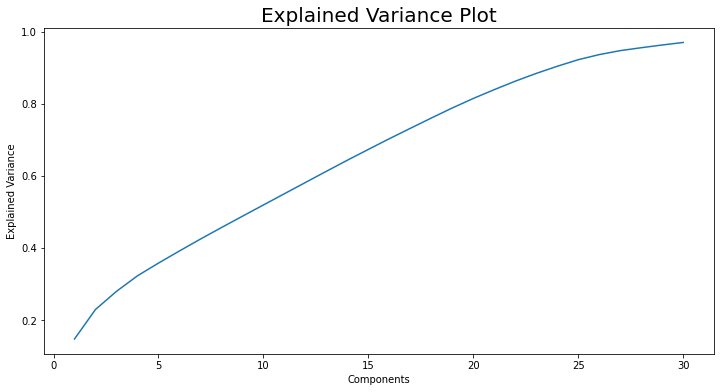

In [ ]:
pca = PCA(n_components=30)
pca.fit(X_scaled)
# TO DO plot for explained variance

x = [i for i in range(1,31)]
y = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12,6))
plt.plot(x,y)
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Plot', fontdict={'fontsize': 20})
plt.show()

The analysis shows that it takes about 27 components to explain almost 90% of the variance in the data, and to reach a point of diminishing returns. Since this does not significantly help us in reducing the dimensions, we decide to not use the reduced data for our modeling.<br><br>

Since it is highy complex to visualise high dimensional data, we extract the first three components of our data in order to visualise it in 3D. We take a subset of the first 5000 data points for the purpose of plotting.

In [ ]:
pca_plot = PCA(n_components=3)
comp = pd.DataFrame(pca_plot.fit_transform(X_scaled), columns=['pca_1', 'pca_2', 'pca_3'])

fig = px.scatter_3d(comp[0:5000], x='pca_1', y='pca_2', z='pca_3', title='PCA: 3 dimensions')
fig.update_layout(title_text='PCA: 3 dimensions', title_x=0.5)
fig.show()

## Clustering

Even though we have a response variable for our data, we decided to perform unsupervised learning on our feature set to identify any underlying patterns within the data. For this purpose, we decide to perform cluster analysis on our data.<br>
The findings from this approach can be used to understand our data at a higher level, and to grasp any apparent similarities among subsets of customers. Moreover, if these findings hold intuitive value, we canstore the clusters as additional features which can be further used for supervised learning.<br>

### Agglomerative Clustering

We first attempt agglomerative clustering on our data with an arbitrary value for k=4 as the number of clusters. We then visualise our clusters in lower dimensions using PCA to see if we can identify any subtantial patterns from the formed clusters.

In [ ]:
AC = AgglomerativeClustering(n_clusters=4)
clusters_ac = AC.fit_predict(X_scaled[:5000])

In [ ]:
pca_plot = PCA(n_components=2)
comp = pd.DataFrame(pca_plot.fit_transform(X_scaled), columns=['pca_1', 'pca_2']).iloc[:5000,:]
comp['cluster'] = clusters_ac.astype('str')

fig = px.scatter(comp, x='pca_1', y='pca_2',
                    color='cluster')
fig.update_layout(title_text='Agglomerative Clustering: 2-dimensional', title_x=0.5)
fig.show()

In [ ]:
pca_plot = PCA(n_components=3)
comp = pd.DataFrame(pca_plot.fit_transform(X_scaled.iloc[:, :-4]), columns=['pca_1', 'pca_2', 'pca_3']).iloc[:5000,:]
comp['cluster'] = clusters_ac.astype('str')

fig = px.scatter_3d(comp[0:5000], x='pca_1', y='pca_2', z='pca_3',
                    color='cluster')
fig.update_layout(title_text='Agglomerative Clustering: 3-dimensional', title_x=0.5)
fig.show()

After visualising the clusters, it is evident that agglomerative clustering does not make a lot of sense on our data, at least in lower dimensions. All of the clusters seem to overlap and the boundaries are not distinct.

### K-means Clustering

The next approach we attempt on our data is K-means clustering. This time, however, we attempt to find the optimal number of clusters using the infamous elbow method. The formed clusters can then be visualized in lower dimensions using PCA.<br>
After visualizing the optimal number of clusters, we try to extract any intuitive information from our findings. For this purpose, we perform corrrelation analysis on our clusters to see how they behave with respect to our features. Lastly, we also store the clusters as additional features for our data, that may be used for supervised learning.

#### Finding Optimal Clusters

In [ ]:
K = range(1,11)
inertias = []

for k in K:
  print('\nK = ' + str(k) +'\n')
  KM = KMeans(n_clusters=k, verbose=1)
  KM.fit(X_scaled)

  inertias.append(KM.inertia_)


K = 1

Initialization complete
Iteration 0, inertia 35253079.939079516.
Iteration 1, inertia 29683209.08523907.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 35508199.18083057.
Iteration 1, inertia 29683209.08523907.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 162268165.4565178.
Iteration 1, inertia 29683209.08523907.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 35814020.3048361.
Iteration 1, inertia 29683209.08523907.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 36752845.20423837.
Iteration 1, inertia 29683209.08523907.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 61997023.10245236.
Iteration 1, inertia 29683209.08523907.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 36668863.62808508.
Iteration 1, inertia 2968320

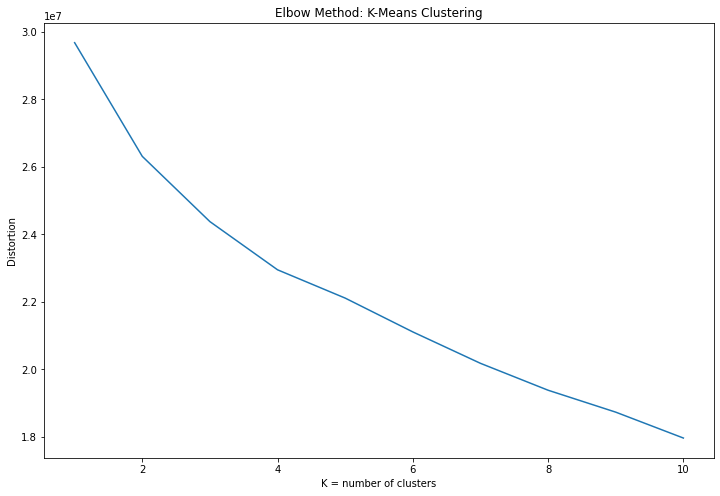

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel('K = number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method: K-Means Clustering')
plt.plot(K, inertias)
plt.show()

Our analysis shows that there is not a significant 'elbow' to use as an optimal number of clusters. However, our graph bends at k=4, so it makes sense to use that as the number of clusters for our analysis.

In [ ]:
KM = KMeans(n_clusters=4)
clusters = KM.fit_predict(X_scaled)

#### Encoding Clusters as Features

In [ ]:
df['cluster_kmeans'] = clusters

df.head()

,age,new_cust,months_as_senior,diff_birth_country,deceased,province,active,income,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,is_male,province_actual_labels,segment_graduate_academic,segment_individual,segment_top,cluster_kmeans
cust_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15902,58,0,255,0,0,0.037073,1,230408,0,0,0,17,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1,0
16232,54,0,253,0,0,0.037073,0,149565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0,0
16274,60,0,253,0,0,0.037073,0,96276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0,0
16339,55,0,253,0,0,0.037073,1,197736,0,0,0,17,0,17,0,0,0,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,MADRID,0,0,1,3
16510,47,0,252,0,0,0.037069,1,213265,1,0,0,16,0,17,0,0,17,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1,3


In [ ]:
dummies = pd.get_dummies(df['cluster_kmeans'], prefix='cluster_kmeans')

dummies.head()

,cluster_kmeans_0,cluster_kmeans_1,cluster_kmeans_2,cluster_kmeans_3
cust_code,,,,
15902,1,0,0,0
16232,1,0,0,0
16274,1,0,0,0
16339,0,0,0,1
16510,0,0,0,1


In [ ]:
df = pd.concat([df, dummies], axis=1).drop(columns='cluster_kmeans')

df.head()

,age,new_cust,months_as_senior,diff_birth_country,deceased,province,active,income,securities_may,savings_acct_months,guarantees_months,cuurent_acct_months,derivada_acct_months,payroll_acct_months,junior_acct_months,max_particular_acct_months,particular_acct_months,particular_plus_acct_months,short_term_deposits_months,medium_term_deposits_months,long_term_deposits_months,e_account_months,funds_months,mortgage_months,pensions_months,loans_months,taxes_months,credit_card_months,home_account_months,direct_debit_months,imputed_payroll_months,imputed_pensions_2_months,cust_type_changes,rel_type_changes,months_since_first_contract,joining_channel_KAS,joining_channel_KAT,joining_channel_KFA,joining_channel_KFC,joining_channel_KHD,joining_channel_KHE,joining_channel_KHK,joining_channel_KHM,joining_channel_KHN,joining_channel_KHQ,joining_channel_RED,is_spain_residence_country,is_employee,cust_type_1,cust_type_2,cust_type_3,cust_type_4,cust_type_P,rel_type_A,is_male,province_actual_labels,segment_graduate_academic,segment_individual,segment_top,cluster_kmeans_0,cluster_kmeans_1,cluster_kmeans_2,cluster_kmeans_3
cust_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15902,58,0,255,0,0,0.037073,1,230408,0,0,0,17,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1,1,0,0,0
16232,54,0,253,0,0,0.037073,0,149565,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0,1,0,0,0
16274,60,0,253,0,0,0.037073,0,96276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,MADRID,0,1,0,1,0,0,0
16339,55,0,253,0,0,0.037073,1,197736,0,0,0,17,0,17,0,0,0,17,0,0,0,0,0,0,17,0,17,17,0,17,15,15,0,0,253,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,MADRID,0,0,1,0,0,0,1
16510,47,0,252,0,0,0.037069,1,213265,1,0,0,16,0,17,0,0,17,17,0,0,0,17,17,0,17,0,17,17,0,17,16,16,0,0,252,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,MADRID,0,0,1,0,0,0,1


#### Visualising Clusters

In [ ]:
#Visualising the clusters for 2 principal components

pca_plot = PCA(n_components=2)
comp = pd.DataFrame(pca_plot.fit_transform(X_scaled), columns=['pca_1', 'pca_2'])
comp['cluster'] = clusters.astype('str')

fig = px.scatter(comp[0:5000], x='pca_1', y='pca_2',
                    color='cluster')
fig.update_layout(title_text='K-Means Clustering: 2-dimensional', title_x=0.5)
fig.show()

In [ ]:
#Visualising the clusters for 3 principal components

pca_plot = PCA(n_components=3)
comp = pd.DataFrame(pca_plot.fit_transform(X_scaled), columns=['pca_1', 'pca_2', 'pca_3'])
comp['cluster'] = clusters.astype('str')

fig = px.scatter_3d(comp[0:5000], x='pca_1', y='pca_2', z='pca_3',
                    color='cluster')
fig.update_layout(title_text='K-Means Clustering: 3-dimensional', title_x=0.5)
fig.show()

The clusters formed by this approach seem to represent distinct boundaries, and therefore, might hold important information about the type of customers that fall within each cluster.<br>
To further explore the characteristics of customers within each cluster, we perform correlation analysis on our clusters against the feature set.

#### Correlation Heatmap

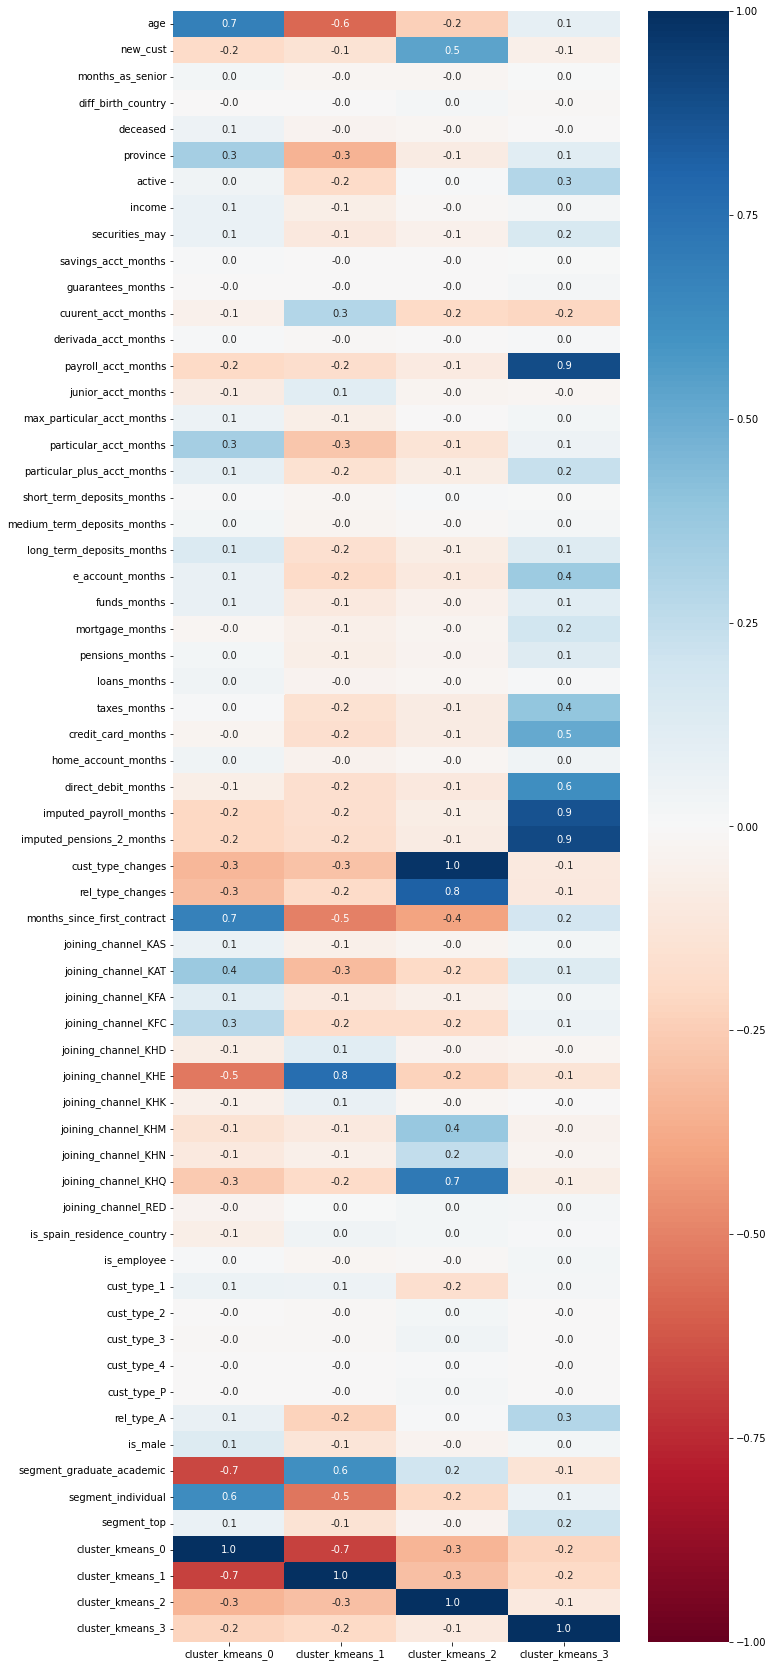

In [ ]:
cor = df.corr().iloc[:, -4:]

plt.figure(figsize=(10,30))
sns.heatmap(cor, annot=True, fmt='.1f', cmap='RdBu', vmin=-1, vmax=1)
plt.show()

**Cluster 0 (blue in scatterplot)**: This cluster has a high correlation of 0.7 with *age*, which shows that it represents the older customers in our data. This cluster is also unlikely to have customers from the KHE joining channel, and these are mostly customers who fall in the inidividual segment.<br>

**Cluster 1 (green in scatterplot)**: Contrary to cluster 0, this cluster has a negative correlation of 0.6 with *age*. So, it represents the relatively younger customers in our data. Correlation with *segment_graduate_academic* is 0.6, so this shows us that most of the customers in this cluster are graduate academics (advanced degree holders). A correlation of 0.8 with *joining_channel_KHE* shows that most of the customers are from that joining channel.<br>

**Cluster 2 (purple in scatterplot)**: There is a perfect correlation of 1.0 with *cust_type_changes* and a 0.8 correlation with *rel_type_changes*. Therefore, the most important characteristic of this subset of customers is that they have changed their customer types and relation types over the given time period. A relatively less important characteristic can be found from the positive correlation of 0.5 with *new_cust*, which shows that a high number of customers in this cluster have joined the bank in the last 6 months.<br>

**Cluster 3 (red in scatterplot)**: A high correlation of 0.9 with *imputed_payroll_months* and *imputed_pensions2_months* shows that the customers within this clsuter are the people who have been working in the job sector. Most of the customers in this cluster also hold a credit card. Another point to note is that this cluster has a the highest correlation of 0.2 (among all clusters) with our response variable *securities_may*. This shows us that people who have a payroll and a pensions account are more likely to open, or keep, a securities account in the coming month. We will explore this relationship further in the next part of modeling.<br>

In [ ]:
# Save to Google Drive
df.to_csv('/content/drive/MyDrive/CIS 545 Project/mod_unsup_2.csv')